In [1]:
import datetime as dt
import os

import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler
from src.step3_modeling.ensemble import DefaultEnsemble
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase
from src.step3_modeling.var_models import VAR
from src.step3_modeling.multivariate import LakeMVT
from src.utils import create_rnbs_snapshot

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
def preprocess_data(split_date, lake_data, validation_steps=12, num_years_ahead=1):
    x_scaler = XArrayScaler()
    y_scaler = XArrayScaler()

    lake_snapshot = create_rnbs_snapshot(rnbs_data=lake_data.sel(variable="rnbs"),
                                         covariates=lake_data.sel(variable=["runoff", "evap", "precip"]),
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    lake_snapshot = lake_snapshot.apply_transformer(x_transformer=x_scaler, y_transformer=y_scaler)
    return lake_snapshot


lake_data = load_data(["rnbs", "precip", "evap", "runoff"]).dropna("Date").to_array().transpose("Date", "lake", ...)
train_split = dt.datetime(1999, 12, 1)
snapshot = preprocess_data(train_split, lake_data)

scaled_lake_data = XArrayScaler().fit_transform(lake_data)

snapshot.train_y
snapshot.train_x

# original_values = snapshot.y_transformer.inverse_transform(snapshot.test_y)
# original_values

<xarray.DataArray (Date: 588, lake: 4, variable: 3)>
array([[[-9.86843709e-01,  4.81822063e-01,  1.06657444e+00],
        [ 8.02280610e-01,  1.44413814e+00,  7.24167486e-01],
        [ 3.80022545e+00, -6.14544616e-01,  2.23271641e+00],
        [ 8.07494235e-01,  1.27122367e+00,  1.17800518e+00]],

       [[-1.05034032e+00, -5.18271035e-01, -9.09121071e-01],
        [-1.69496451e-01,  3.31970570e-01, -4.96614499e-02],
        [ 1.81219325e+00, -5.93496936e-01,  8.83356463e-01],
        [-2.31943634e-01,  8.81008985e-01,  5.15948859e-01]],

       [[-9.51514551e-01, -6.43758907e-01, -2.17838719e-01],
        [ 1.92074280e+00,  7.67643724e-02, -8.30826331e-02],
        [ 2.47219757e+00, -7.15897290e-01,  4.38120428e-01],
        [ 1.48184288e+00,  5.67885481e-02,  1.36006757e-02]],

       ...,

       [[-6.82784706e-01,  8.28282887e-01,  7.52419157e-01],
        [-9.32964574e-01,  5.26004782e-01,  1.83919567e-01],
        [-9.85809597e-01,  2.07502506e+00, -1.08188747e+00],
        [-7.62046337e-01,  7.88964063e-01, -9.49650180e-01]],

       [[-4.92283795e-01,  1.40071713e+00,  4.70981049e-01],
        [-7.50798843e-01,  9.44520802e-01,  2.85755239e-03],
        [-9.70530277e-01,  1.21838449e+00, -1.10329604e+00],
        [-7.42240390e-01,  7.15328126e-01, -8.09592934e-01]],

       [[-3.66871599e-01,  2.06077857e+00, -1.88991313e-01],
        [-7.57848722e-01,  1.26643491e+00, -6.44264699e-01],
        [-9.13772395e-01,  6.51878090e-01, -9.05964943e-01],
        [-6.14766859e-01,  1.04529522e+00, -8.58184223e-01]]])
Coordinates:
  * Date      (Date) datetime64[ns] 1950-01-01 1950-02-01 ... 1998-12-01
  * lake      (lake) object 'sup' 'mic_hur' 'eri' 'ont'
  * variable  (variable) object 'runoff' 'evap' 'precip'

In [3]:
models = {
    # "VARX": VAR(lags={"y": 3, "runoff": 3, "precip": 6, "evap": 2}, num_chains=4, num_samples=1000, num_warmup=1000),
    # "VAR": VAR(lags={"y": 3}, num_chains=4, num_samples=1000, num_warmup=500),
    # "MVT": LakeMVT(),
    "Default": DefaultEnsemble()
}

In [4]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_lake_data.sel(variable="rnbs").rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot = preprocess_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=12)

        months_ahead = xr.DataArray(np.arange(1, 13), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot = preprocess_data(train_split, lake_data)
all_model_results = []
for name, model in models.items():
    fitted_model = fit_model(snapshot, model)
    predictions = run_forecasts(train_split, model).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

value,Date,lake,months_ahead,true,lower,mean,std,upper,model
0,2000-01-01,eri,1.0,-0.672800,-0.888542,0.158457,0.804986,1.915436,Default
1,2000-01-01,mic_hur,1.0,-0.997913,-1.295564,-0.490981,0.480505,0.341894,Default
2,2000-01-01,ont,1.0,-0.531159,-1.293129,-0.095628,0.698034,1.276609,Default
3,2000-01-01,sup,1.0,-1.102221,-1.535737,-1.035405,0.319011,-0.322557,Default
4,2000-02-01,eri,2.0,0.164472,-0.460771,0.520632,0.719036,2.100349,Default


In [5]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

,,rmse,variance,bias,coverage,interval_len,crps,N
months_ahead,model,,,,,,,
1.0,Default,0.625932,0.391648,0.011942,0.913223,2.155240,0.347663,484.0
2.0,Default,0.626540,0.392402,0.012294,0.911157,2.155396,0.348096,484.0
3.0,Default,0.627022,0.392998,0.012609,0.911157,2.157786,0.348496,484.0
4.0,Default,0.636392,0.404553,0.021005,0.904959,2.159045,0.352888,484.0
5.0,Default,0.637165,0.405569,0.020267,0.904959,2.158189,0.353193,484.0
6.0,Default,0.635753,0.403823,0.018935,0.904959,2.154743,0.352411,484.0
7.0,Default,0.631133,0.397596,0.027072,0.904959,2.153092,0.349312,484.0
8.0,Default,0.630480,0.396656,0.029127,0.902893,2.152597,0.348777,484.0
9.0,Default,0.630028,0.396105,0.028829,0.902893,2.156632,0.348672,484.0


/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanea

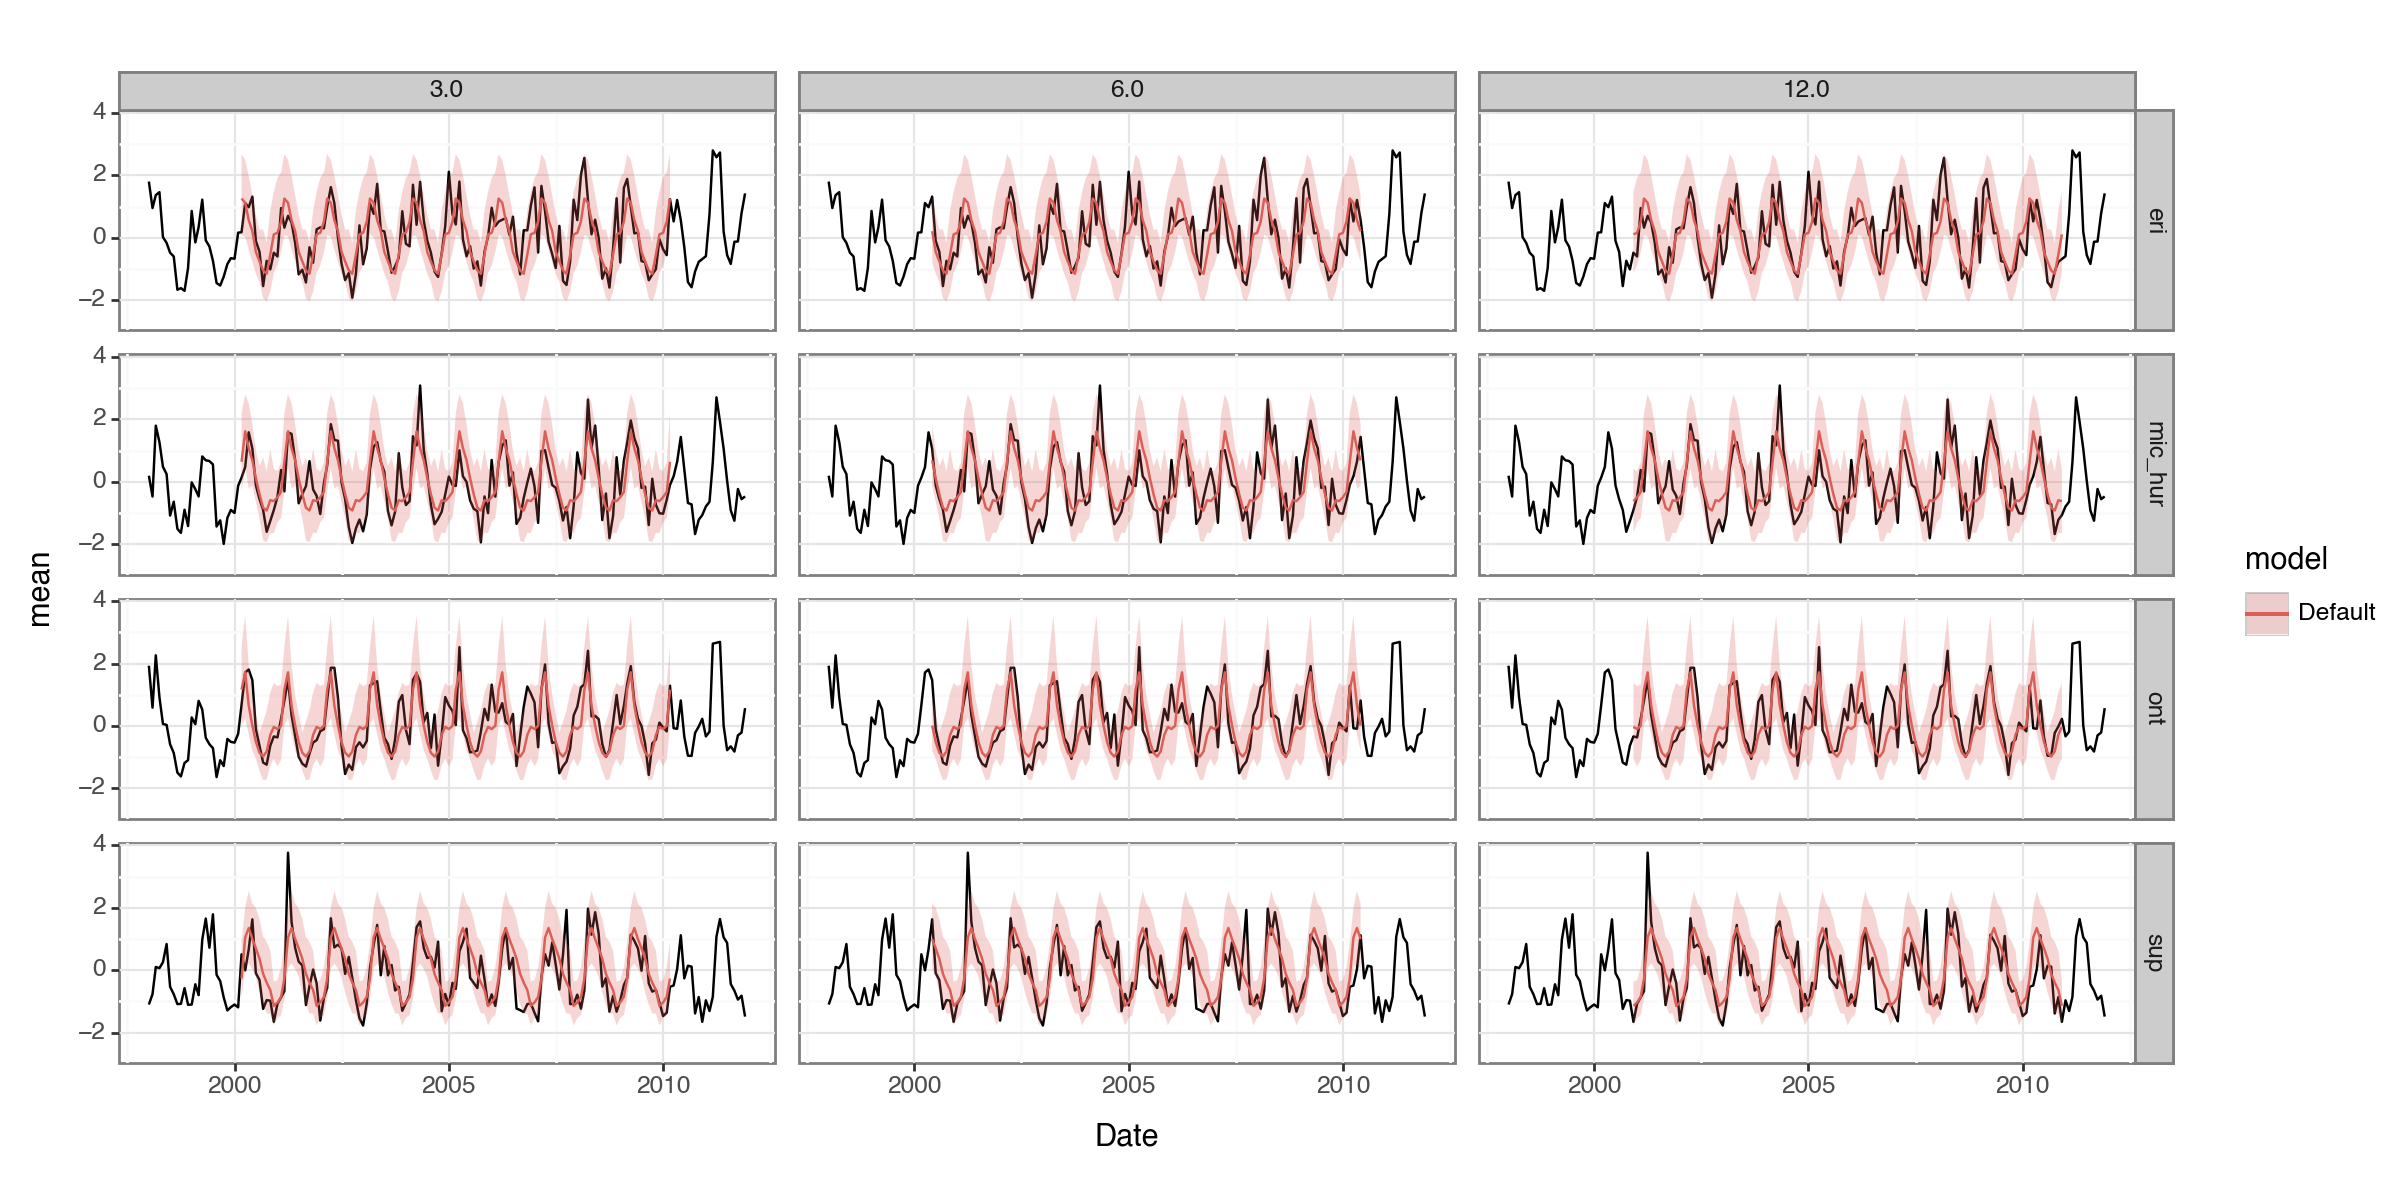

<Figure Size: (1200 x 600)>

In [6]:
og = scaled_lake_data.sel(variable="rnbs").to_dataframe(name="rnbs").reset_index().drop({"variable"}, axis=1)
result_subset = results_df[results_df["months_ahead"].isin([3, 6, 12])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean", fill="model"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean", color="model"))
        + facet_grid("lake~months_ahead")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"),
    alpha=0.25,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)
